In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

## Chap. 7 Ensemble Learning and Random Forests

個々では weak classifier としてしか機能しないモデルでも、場合によっては組み合わせることで高い予測能力を出すことができる (Ensembling)

大数の法則のはなし

In [2]:
def plot_7_3():
    plt.figure(figsize=(8,3.5))
    plt.plot(cumulative_heads_ratio)
    plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
    plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
    plt.xlabel("Number of coin tosses")
    plt.ylabel("Heads ratio")
    plt.legend(loc="lower right")
    plt.axis([0, 10000, 0.42, 0.58])
    plt.show()

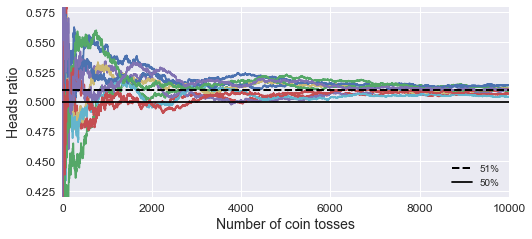

In [4]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plot_7_3()

## Voting classifiers

moons データセットにおいて、random forest, logistic regression, SVC を訓練して、それぞれの予測精度と、それらの ensemble model (voting classifier)との精度を比較する 

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

# hard voting: 多数決
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [14]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


/Users/Junichiro/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
# soft voting にして、各クラスの予測の確率を平均するようにする
svm_clf = SVC(probability=True, random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


/Users/Junichiro/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Ensembling は予測のに相関がないときに有用。利点は以下のようにまとめられる。

- 平均を取ることでノイズで異なっている予測を採用することを避けられる


- greedy アルゴリズムなどで local optima に落ちる問題を様々な初期条件やモデルを用意することで多少避けられる


- データセットが有限であることによって、一つ一つのモデルが表現できる空間に制約が入るが、複数のモデルを採用することで、この表現空間を広げられる(かもしれない)


"The first reason is statistical. When the learning set is too small, a learning algorithm can typically find several models in the hypothesis space $\mathcal{H}$ that all give the same performance on the training data. Provided their predictions are uncorrelated, averaging several models reduces the risk of choosing the wrong hypothesis. The second reason is computational. Many learning algorithms rely on some greedy assumption or local search that may get stuck in local optima. As such, an ensemble made of individual models built from many different starting points may provide a better approximation of the true unknown function than any of the single models. Finally, the third reason is representational. In most cases, for a learning set of finite size, the true function cannot be represented by any of the candidate models in $\mathcal{H}$. By combining several models in an ensemble, it may be possible to expand the space of representable functions and to better model the true function."
[Louppe and Gilles, arXiv:1407.7502](https://arxiv.org/abs/1407.7502)

## Bootstrap AGGregation (Bagging)

データセットを小さなデータセットに分けて、それぞれのデータセットで訓練したモデルで多数決をさせる(回帰の場合は予測の平均を取る)。

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('500 decision trees: ',accuracy_score(y_test, y_pred))

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('single decision tree: ',accuracy_score(y_test, y_pred_tree))

500 decision trees:  0.904
single decision tree:  0.856


In [24]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
def plot_7_5():
    plt.figure(figsize=(11,4))
    plt.subplot(121)
    plot_decision_boundary(tree_clf, X, y)
    plt.title("Decision Tree", fontsize=14)
    plt.subplot(122)
    plot_decision_boundary(bag_clf, X, y)
    plt.title("Decision Trees with Bagging", fontsize=14)
    plt.show()

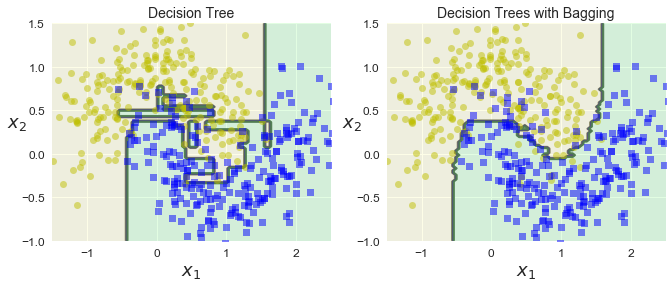

In [26]:
# single decision tree vs bagging ensemble of 500 trees
plot_7_5()

## Random Forests

Random forest では以下のような randomness を実装することで予測精度を上げている

- Bagging を通して異なるデータのサブセットで訓練された決定木を用意する.


- それぞれのノードでの split において、ランダムな feature subset を用意することで制限をかけ,それぞれのモデルのcorrelationを下げる. ←  "feature bagging"


- 評価関数を最適化するようにsplitせず、random性を入れたプロセスでsplitさせる. (Extremely Randomized Trees, sklearn.ensemble.ExtraTreeClassifier)

Geurts, Pierre, Damien Ernst, and Louis Wehenkel (2006),“Extremely randomized trees,” Machine learning 63 (1), 3–42.

Bagging された500の決定木と同じ n_estimators=500 の Random Forestを比較

In [28]:
from sklearn.ensemble import RandomForestClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

decision tree では、leaf より root に近い方が重要な特徴量だといえる。<font color="Green">rnd_clf.feature_importances  </font>　を使うことで、それぞれの特徴量がsplitに使われている深さの平均(?)を特徴量の重要度として取り出せる

In [59]:
# print feature importance for Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [104]:
import io
from urllib.request import urlopen
from scipy.io.arff import loadarff
def fetch_mnist():
    content = urlopen(
        'https://www.openml.org/data/download/52667/mnist_784.arff').read()
    data, meta = loadarff(io.StringIO(content.decode('utf8')))
    data = data.view([('pixels', '<f8', 784), ('class', '|S1')])
    return data['pixels'], data['class']

mnist_data, mnist_target = fetch_mnist()
mnist_target = np.ascontiguousarray(mnist_target, dtype=np.float32)

In [102]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.viridis,
               interpolation="nearest")
    plt.axis("off")

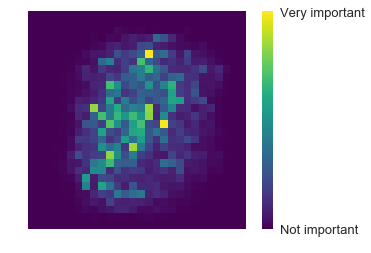

In [105]:
# print feature importance for MNIST

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist_data, mnist_target)

plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'],fontsize=13)
plt.show()

## Boosting

- Bagging では、ensemble の中のモデルの重みは全て一緒であった

- Boosting では、逐次的に ensemble のモデルを増やし、重みも update していく

### AdaBoost classifier algorithm (binary classifier の場合)

data set $\mathcal{L}=\{(\vec{x_i},y_i),\,i=1,\cdots, N\}$, where $\vec{x_i}\in \mathcal{X}$, $y_i\in\mathcal{Y}=\{+1,-1\}$. $\mathcal{H}=\{h:\mathcal{X}\rightarrow\mathcal{Y}\}$: family of classifiers


- **Initialize** $w_{t=1}(\vec{x_n})=1/N, n=1,\cdots,N$


- **For** $t=1\cdots,T$, **do**

    - Select from $\mathcal{H}$ a hypothesis $h_t$ that minimizes the weighted error
    
    $\epsilon_t=\sum_{i=1}^N w_{t}(\vec{x_i})\mathbb{1}(h_t(\vec{x_i})\neq y_i)$
    
    - Let $\alpha_t=\frac{1}{2}\ln\frac{1-\epsilon_t}{\epsilon_t}$, update the weight for each data $\vec{x_n}$ by
    
    $w_{t+1}(\vec{x_n})\leftarrow w_t(\vec{x_n})\frac{\exp[-\alpha_ty_nh_t(\vec{x_n})]}{Z_t}$
    
    where $Z_t=\sum_{n=1}^Nw_t(\vec{x_n})e^{-\alpha_ty_nh_t(\vec{x_n})}$ ensures all weights add up to unity.

    予測が間違ったものの重みを大きくして重み関数 $w_{t}(\vec{x_n})$ を更新する


- **Output** $g_A(\vec{x})=\text{sign}\left(\sum_{t=1}^T\alpha_th_t(\vec{x})\right)$



[Mehta et al., arXiv:1803.08823](https://arxiv.org/abs/1803.08823)

In [35]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

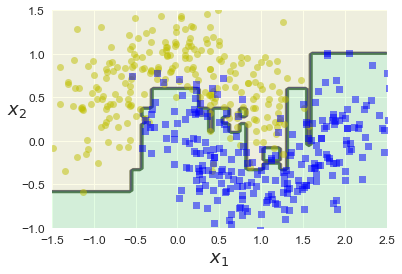

In [39]:
plot_decision_boundary(ada_clf, X, y)

In [40]:
m = len(X_train)
def plot_decision_boundary_for_consecutive_predictors():
    plt.figure(figsize=(11, 4))
    for subplot, learning_rate in ((121, 1), (122, 0.5)):
        sample_weights = np.ones(m)
        plt.subplot(subplot)
        for i in range(5):
            svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
            svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
            y_pred = svm_clf.predict(X_train)
            sample_weights[y_pred != y_train] *= (1 + learning_rate)
            plot_decision_boundary(svm_clf, X, y, alpha=0.2)
            plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
        if subplot == 121:
            plt.text(-0.7, -0.65, "1", fontsize=14)
            plt.text(-0.6, -0.10, "2", fontsize=14)
            plt.text(-0.5,  0.10, "3", fontsize=14)
            plt.text(-0.4,  0.55, "4", fontsize=14)
            plt.text(-0.3,  0.90, "5", fontsize=14)

    plt.show()

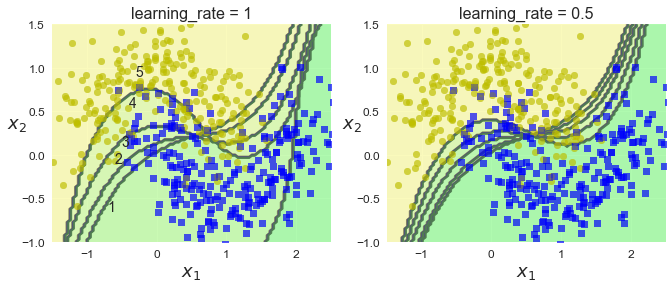

In [41]:
plot_decision_boundary_for_consecutive_predictors()

## Gradient Boosting

Gradient descent と　Boosting とを組み合わせたもの

iteration毎に評価関数を計算し、その評価関数を減らす方向に木を増やしていく

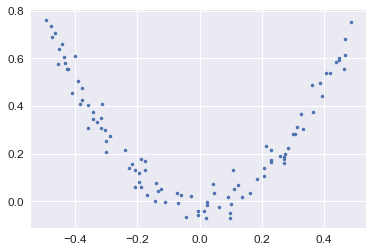

In [64]:
# gradient boosting like な方法で, 以下のデータ点の回帰を与える
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
plt.plot(X,y,'.')

In [62]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [47]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
def gradient_boosting_plot():
    plt.figure(figsize=(11,11))

    plt.subplot(321)
    plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
    plt.ylabel("$y$", fontsize=16, rotation=0)
    plt.title("Residuals and tree predictions", fontsize=16)

    plt.subplot(322)
    plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
    plt.ylabel("$y$", fontsize=16, rotation=0)
    plt.title("Ensemble predictions", fontsize=16)

    plt.subplot(323)
    plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
    plt.ylabel("$y - h_1(x_1)$", fontsize=16)

    plt.subplot(324)
    plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
    plt.ylabel("$y$", fontsize=16, rotation=0)

    plt.subplot(325)
    plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
    plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
    plt.xlabel("$x_1$", fontsize=16)

    plt.subplot(326)
    plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$y$", fontsize=16, rotation=0)

    plt.show()

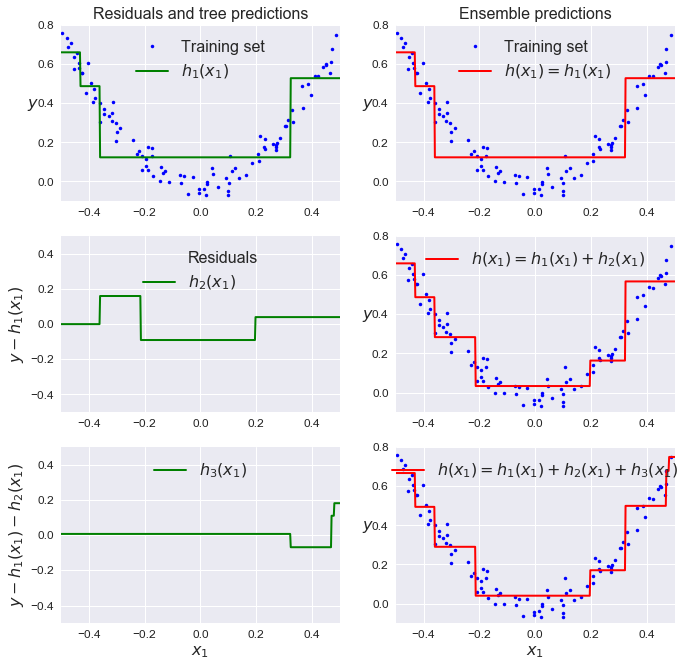

In [48]:
gradient_boosting_plot()

learning rate を小さくすると、最適な forest に必要な木の数が増えていくが、モデルはより一般化される (shrinkage) .


In [86]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=10, learning_rate=0.1, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=80, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=80, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [87]:
def gbrt_learning_rate_plot():
    plt.figure(figsize=(11,4))

    plt.subplot(121)
    plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
    plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

    plt.subplot(122)
    plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
    plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

    plt.show()

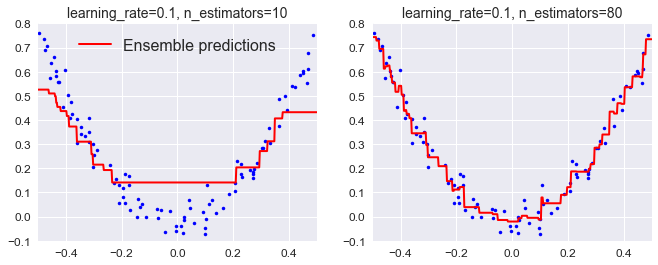

In [88]:
gbrt_learning_rate_plot()

最適な木の数 (n_estimators) はどのように決めれば良いか？

→ validation set を設けて、validation error が最低となる n_estimators を見つければ良い
(Early stopping (4章))

In [80]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, learning_rate=0.1, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, learning_rate=0.1,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [91]:
def early_stopping_gbrt_plot():
    plt.figure(figsize=(11, 4))

    plt.subplot(121)
    plt.plot(errors, "b.-")
    plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
    plt.plot([0, 120], [min_error, min_error], "k--")
    plt.plot(bst_n_estimators, min_error, "ko")
    plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
    plt.axis([0, 120, 0, 0.01])
    plt.xlabel("Number of trees")
    plt.ylabel("Mean Squared Error")
    plt.title("Validation error", fontsize=14)

    plt.subplot(122)
    plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
    plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
    plt.show()

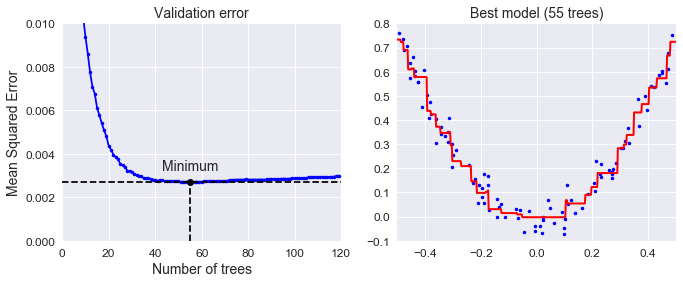

In [92]:
min_error = np.min(errors)
early_stopping_gbrt_plot()

In [99]:
# early stopping
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping
print('gbrt.n_estimators = ',gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

gbrt.n_estimators =  61
Minimum validation MSE: 0.002712853325235463


## XGBoost (Extreme Gradient Boosting)

少し sophisticate(?) された gradient boosting. 

- 木の構造を regulate する項が評価関数に入っている

- それぞれの木が less-correlated になるように extra randomization が入っている

そのほかにも色々なテクニックが実装されているらしい。。。詳細は [Mehta et al., arXiv:1803.08823](https://arxiv.org/abs/1803.08823) などを参照

In [97]:
import xgboost

xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[26]	validation_0-rmse:0.051226
[27]	validation_0-rmse:0.051135
[28]	validation_0-rmse:0.05091
[29]	validation_0-rmse

In [98]:
print("Validation MSE by Gradient Boosting:", min_val_error)
print("Validation MSE by XGBoost:", val_error)

Validation MSE by Gradient Boosting: 0.002712853325235463
Validation MSE by XGBoost: 0.0025349167568108864
